# RPCA with IRCUR 

We perform RPCA using IRCUR algorithm. IRCUR implementation source: https://github.com/sverdoot/robust-pca.

Dataset consists of 30 video frames from 3 scenes from movie "Hobbit" (Sampled from: https://www.kaggle.com/datasets/akshaybapat04/frames-from-video).

Frames from the same scene form low dimensional data: first frame (dim 1) + motion (dim 0-1), so data of each scene should be rank 1-2 + noise.
We set rank upper limit to 3, our smallest estimate.

In [1]:
import os
os.chdir("..")
os.getcwd() # should be project root dir

'C:\\Users\\januszs\\Projects\\myfinaltest\\IRCUR-hobbit'

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from robustpca.ircur import IRCUR # stored locally

## LOAD DATA

In [3]:
def ReadImageFromPath(path): #     # cv2.imread(path.as_posix())
    return cv2.imread(path)[:,:, 0] #take just first out of three pixel coordinates

In [4]:
def ImageToVector(image):
    #image is a 3d array
    return image.reshape((image.size,))

def VectorToImage(vector, image_shape):
    #vector is a reshaped 3d array that contained image of shape image_shape
    return vector.reshape(image_shape)

In [5]:
DATASET_DIR_PATH = os.path.join(os.getcwd(), r"data\hobbit_dataset_selection")
frames_paths = [os.path.join(DATASET_DIR_PATH, filename) for filename in
                os.listdir(DATASET_DIR_PATH)]
#
len(frames_paths) # number of frames

30

In [6]:
no_of_scenes = 3 # prior knowledge of dataset

In [7]:
chosen_frame = ReadImageFromPath(frames_paths[0])
frame_shape = chosen_frame.shape
frame_shape

(720, 1280)

In [8]:
frames_as_arrays = np.array([ReadImageFromPath(frame_path) for frame_path in frames_paths])

In [9]:
N = frames_as_arrays.shape[0]
N # number of frames

30

In [10]:
m = no_of_scenes #number of images shown for preview
m

3

In [11]:
np.random.seed(seed=1) # seed chosen to be representative for scenes
frames_to_show_ind = N//no_of_scenes * np.array(range(no_of_scenes)) + np.random.randint(low=0, high=N//no_of_scenes, size=m)
#
assert len(set(frames_to_show_ind)) == m
frames_to_show_ind

array([ 5, 18, 29])

In [12]:
frames = np.array([ImageToVector(frame_as_array) 
                   for frame_as_array in frames_as_arrays]) # main data matrix

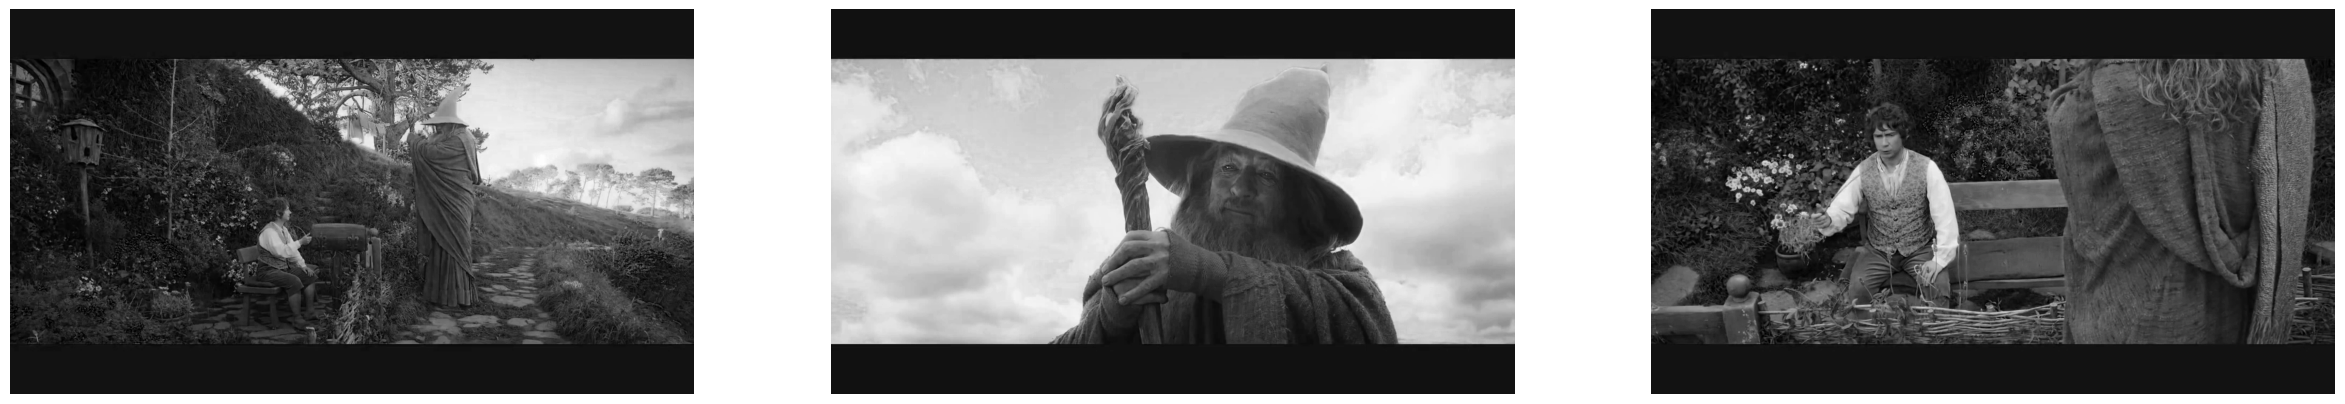

In [13]:
#pictures preview
fig, axs = plt.subplots(1,m, figsize=(30,30))
for ax in axs:
    ax.axis('off')

for i,j in enumerate(frames_to_show_ind):
    axs[i].imshow(VectorToImage(frames[j], image_shape=frame_shape), cmap="gray")

In [14]:
original_rank = np.linalg.matrix_rank(frames)
original_rank

30

## APPLY IRCUR

In [15]:
def my_stats(L, S, name, threshold):
    # some stats regarding how well compressed data D is with L and S
    # name is the name of this pair L,S (e.g. name of method that produced them, like PCP, IRCUR)
    L_rank = np.linalg.matrix_rank(L)
    original_nrow = S.shape[0]
    original_ncol = S.shape[1]
    L_relsize = L_rank * (L_rank + original_nrow + original_ncol)/(original_nrow * original_ncol)
    S_relsize = (np.abs(S) > threshold).mean()
    #
    stats_dict = {'name':name, "L_rank":L_rank,
                  #"original_nrow":original_nrow, "original_ncol":original_ncol,
                  "L_relsize":L_relsize, "S_relsize":S_relsize, "_threshold":threshold}
    return stats_dict

def my_stats_as_df(L, S, name, threshold):
    # returns: my_stats but as pd.DataFrame
    
    stats_dict = my_stats(L, S, name, threshold)
    for key, val in [(key,val) for (key,val) in stats_dict.items() if key!="name"]:
        stats_dict[key] = [val] # make val a one-element list (except if it holds the name)
    
    df = pd.DataFrame.from_dict(stats_dict).set_index('name')
    return df

In [16]:
pcp_alm = IRCUR()
rank = 3 # 3 = for each of 3 scenes: 1dim
c = 4 # recommended in the paper
nrows, ncols = int(c * rank * np.log(frame_shape[0])), int(c * rank * np.log(frame_shape[1])) # recommended in the paper

In [17]:
L_ircur, S_ircur = pcp_alm.decompose(frames, rank, nrows, ncols,
                                     thresholding_decay=0.9, initial_threshold=100, verbose=True)

Iteration: 103, diff: 9.441151119011154e-06, terminating alg.
Elapsed: 378.05


## Evaluate

In [18]:
my_stats_as_df(L_ircur, S_ircur, name="IRCUR", threshold=0.05).round(2)
# L_relsize: number of entries of an optimal CUR decomposition (computed from rank)
# S_relsize: number of non-negligible entries of S, up to threshold

,L_rank,L_relsize,S_relsize,_threshold
name,,,,
IRCUR,3,0.1,0.3,0.05


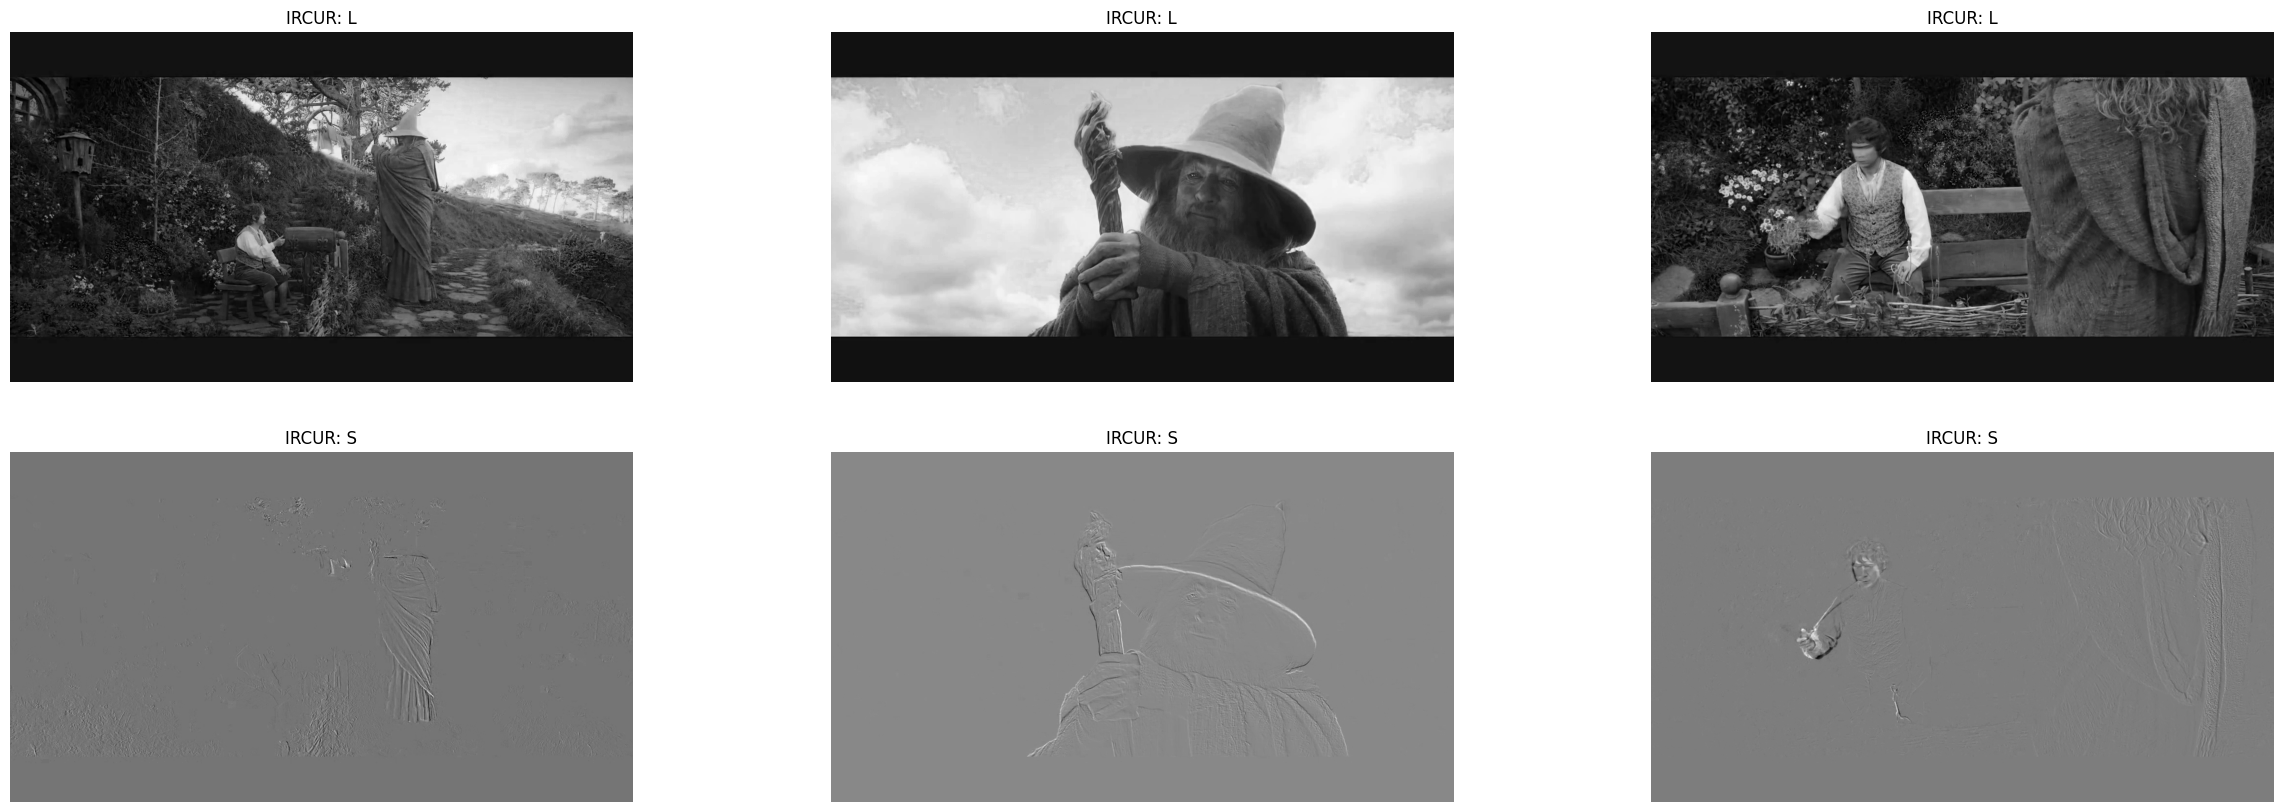

In [19]:
#preview: decomposition
fig, axs = plt.subplots(2,m, figsize=(30,10))
for ax in axs.flatten():
    ax.axis('off')

for i,j in enumerate(frames_to_show_ind):
    axs[0][i].imshow(VectorToImage(L_ircur[j], image_shape=frame_shape), cmap="gray")
    axs[0][i].set_title("IRCUR: L")
    axs[1][i].imshow(VectorToImage(S_ircur[j], image_shape=frame_shape), cmap="gray")
    axs[1][i].set_title("IRCUR: S")

## Conclusion

We used low rank (3) (the other notebook contains high rank (6)). <br>
Still, each frame was successfully decomposed into: main content of the scene + sparse noise.

Sparse part has roughly 30% non-negligible entries (with threshold 0.05).

High rank (6) and low rank (3) IRCUR had similar effect. Low rank ran approximately 2 times faster (... vs 378 seconds in one trial).